In [1]:
import sys
sys.path.append('../src')

import numpy as np
import joblib
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

import simulation

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{siunitx}\usepackage{sansmath}\sansmath')
params = {
    'legend.fontsize': 9,
    'axes.labelsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
}
plt.rcParams.update(params)

In [3]:
cerro_toco_atm_profile = np.loadtxt('../input-data/cerro_toco_atm_profile.txt')

In [4]:
mag_vec = SkyCoord(-5.9, 21.2, frame='altaz', unit='deg')
obs_direction = SkyCoord(0, 45, frame='altaz', unit='deg')
bc = 38.0
bw = 5.7

In [5]:
def run_calc(start_alt):
    simulator = simulation.AtmSim(22738, cerro_toco_atm_profile, 5200, start_alt)
    return simulator.calc_propagation_matrix_avg_band(bc - bw, bc + bw, 5, mag_vec.separation(obs_direction).rad, obs_direction.zen.rad)[3]

In [6]:
start_alts = np.linspace(5200, 20000, 75)
cumulative_v = joblib.Parallel(n_jobs=10)(joblib.delayed(run_calc)(start_alts[i]) for i in range(start_alts.size))

In [7]:
v_fraction = np.array(cumulative_v) / max(cumulative_v)

In [8]:
np.savez_compressed('../result-data/altitude-cumulative-v.npz', start_alts=start_alts, v_fraction=v_fraction)

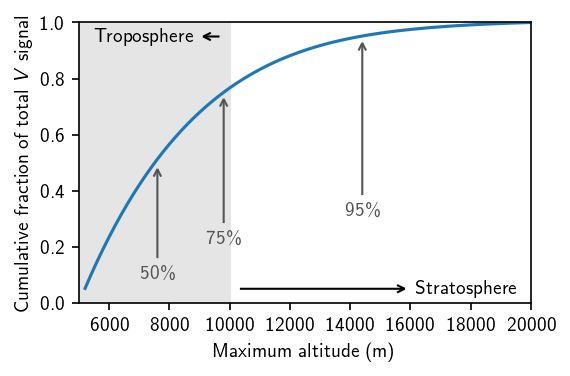

In [9]:
plt.figure(figsize=(3.9, 2.6), dpi=150)

plt.plot(start_alts, v_fraction)

plt.axvspan(0, 10000, color='#e5e5e5')
plt.annotate('Troposphere', xy=(9800, 0.95), xytext=(5500, 0.95), arrowprops=dict(arrowstyle='<-', capstyle='butt', joinstyle='miter'), horizontalalignment='left', verticalalignment='center', fontsize=9)
plt.annotate('Stratosphere', xy=(10200, 0.05), xytext=(19500, 0.05), arrowprops=dict(arrowstyle='<-', capstyle='butt', joinstyle='miter'), horizontalalignment='right', verticalalignment='center', fontsize=9)

color = '#555555'
for frac in [0.5, 0.75, 0.95]:
    x = start_alts[np.searchsorted(v_fraction, frac)]
    plt.annotate(f'{int(frac * 100)}\%', xy=(x, frac), xytext=(x, 0.5 * frac - 0.15), arrowprops=dict(arrowstyle='->', capstyle='butt', joinstyle='miter', color=color), horizontalalignment='center', verticalalignment='center', fontsize=9, color=color)

plt.xlim((5000, 20000))
plt.ylim((0, 1))

plt.ylabel('Cumulative fraction of total $V$ signal')
plt.xlabel('Maximum altitude (m)')

plt.tight_layout()

plt.savefig('../result-data/altitude-cumulative-v.pdf')